# Importing Stuff

In [1]:
import torch
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
import torchvision

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image
import json

from torchvision import transforms, datasets

from circuit_explorer.data_loading import rank_image_data, single_image_data
from circuit_explorer.utils import load_config
from circuit_explorer.utils import get_layers_from_model

from lucent_circuit.optvis import render, param, transform, objectives
from circuit_explorer.mask import setup_net_for_mask

import random


import hdbscan
import warnings

from circuit_explorer.receptive_fields import receptive_field, receptive_field_for_unit
from circuit_explorer.target import layer_saver

warnings.filterwarnings('ignore')


In [2]:
from dataset.Dataset_Utils import ImageNetKaggle, ImageNetReceptiveField

In [3]:
device = 'cuda:0'

config_file = 'configs/alexnet_sparse_config.py'
config = load_config(config_file)

model = config.model
model = model.to(device)

all_layers = get_layers_from_model(model)
all_layers.keys()

odict_keys(['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'])

In [4]:
all_layers['features.3']

Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

# Defining Datasets

In [5]:
class SingleImage(Dataset):
    def __init__(self, img, label):
        self.img = img
        self.label = label
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        return self.img, self.label

In [6]:
class ImageNetKaggle(Dataset):
    def __init__(self, root, split, transform=None):
        self.samples = []
        self.targets = []
        self.transform = transform
        self.syn_to_class = {}
        
        with open(os.path.join(root, "imagenet_class_index.json"), "rb") as f:
                    json_file = json.load(f)
                    for class_id, v in json_file.items():
                        self.syn_to_class[v[0]] = int(class_id)
        with open(os.path.join(root, "ILSVRC2012_val_labels.json"), "rb") as f:
                    self.val_to_syn = json.load(f)
        samples_dir = os.path.join(root, "ILSVRC/Data/CLS-LOC", split)
        for entry in os.listdir(samples_dir):
            if split == "train":
                syn_id = entry
                target = self.syn_to_class[syn_id]
                syn_folder = os.path.join(samples_dir, syn_id)
                for sample in os.listdir(syn_folder):
                    sample_path = os.path.join(syn_folder, sample)
                    self.samples.append(sample_path)
                    self.targets.append(target)
            elif split == "val":
                syn_id = self.val_to_syn[entry]
                target = self.syn_to_class[syn_id]
                sample_path = os.path.join(samples_dir, entry)
                self.samples.append(sample_path)
                self.targets.append(target)
                
    def __len__(self):
            return len(self.samples)
        
    def __getitem__(self, idx):
            x = Image.open(self.samples[idx]).convert("RGB")
            if self.transform:
                x = self.transform(x)
            return x, self.targets[idx]
        
        
class ImageNetReceptiveField(ImageNetKaggle):
    def __init__(self, root, split, transform=transforms.ToTensor(),
                 background_c =(255,255,255), recep_field=None, img_size=224):
        
        super().__init__(root=root, split=split, transform=transform)
        
        self.root = root
        self.background_c = background_c
        self.img_size = img_size
    
        self.recep_field = recep_field
        
        if self.recep_field:
            self.recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field 

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)

        if self.recep_field is not None:
            img_tensor = torch.zeros(3,self.img_size,self.img_size)
            shrunk_tensor = self.recep_resize(img)
            img_tensor[:,int(self.recep_field[0][0]):int(self.recep_field[0][1]),int(self.recep_field[1][0]):int(self.recep_field[1][1])] = shrunk_tensor
            img = img_tensor
     
        return img, label

In [7]:
class ImageNet2(datasets.ImageFolder):
    def __init__(self, root, split, transform=transforms.ToTensor(),
                 background_c =(255,255,255), recep_field=None, img_size=224):
        
        super().__init__(root=root, transform=transform)
        
        self.root = root
        self.background_c = background_c
        self.img_size = img_size
    
        self.recep_field = recep_field
        
        if self.recep_field:
            self.recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field 

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)

        if self.recep_field is not None:
            img_tensor = torch.zeros(3,self.img_size,self.img_size)
            shrunk_tensor = self.recep_resize(img)
            img_tensor[:,int(self.recep_field[0][0]):int(self.recep_field[0][1]),int(self.recep_field[1][0]):int(self.recep_field[1][1])] = shrunk_tensor
            img = img_tensor
     
        return img, label

In [8]:
model.eval().cuda()
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

preprocessing = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

# Receptive Fields + Dataset

In [9]:
position = [6,6]
# layer = 'features.8'
# unit = 53

#dog/metal feature
# layer = 'features.10'
# unit = 9

#monkey/text feature
layer = 'features.10'
unit = 255


all_recep_field_params = receptive_field(model.features, (3,224,224))
recep_field = receptive_field_for_unit(all_recep_field_params, layer, position)

imagenet_train_dataset = ImageNetReceptiveField('image_data/imagenet', "train", preprocessing, 
                                                recep_field=recep_field)

imagenet_train_dataloader = DataLoader(
            imagenet_train_dataset,
            batch_size=128,
            num_workers=8,
            shuffle=False,
            drop_last=False,
            pin_memory=True
        )

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

In [14]:
imagenet2_train_dataset = ImageNet2('image_data/imagenet_2', preprocessing, 
                                                recep_field=recep_field)

imagenet2_train_dataloader = DataLoader(
            imagenet2_train_dataset,
            batch_size=128,
            num_workers=1,
            shuffle=False,
            drop_last=False,
            pin_memory=True
        )

# Highest K Activations

In [15]:
def k_layer_activations_from_dataloader(layers,dataloader,model,num_units=[384],k=300,position=[6,6],batch_size=64):
    '''
    dataloader: can be a pytorch dataloader or simply a path to an folder with images and no subfolders
    layers: should be a single layer name or list of layer names, for keys in dict "layers = OrderedDict([*model.named_modules()])"
    model: a pytorch nn model, set the device of model to determine devices for all variables in this function
    '''
    device = next(model.parameters()).device
    top300_activations = {}
    layer_num_units = {}
    
    layer_activations = {}
    if isinstance(layers,str):
        layers = [layers]
    for i in layers:
        num_units = get_layers_from_model(model)[i].out_channels
        layer_num_units[i] = num_units
        for unit in range(num_units):
            top300_activations[f'{i}_{unit}'] = []

            
    for dl_idx, (data, labels) in enumerate(tqdm(dataloader)):  
        ds_idxs = list(range(dl_idx*batch_size, (dl_idx+1)*batch_size))
        
        images = data.to(device)
        with layer_saver(model, layers) as extractor:
            batch_layer_activations = extractor(images)
            for i in layers:
                for unit in range(layer_num_units[i]):
                    unit_activations = list(batch_layer_activations[i][:, unit, position[0], position[1]].detach().to('cpu').numpy())
                    tuples_to_add = zip(unit_activations, ds_idxs)
                    
                    for tup in tuples_to_add:
                        if len(top300_activations[f'{i}_{unit}']) < k:
                            heappush(top300_activations[f'{i}_{unit}'], tup)
                        else:
                            heappushpop(top300_activations[f'{i}_{unit}'], tup)

    return top300_activations

In [10]:
target_layer_activations = torch.load('outputs/layer_10/layer_10_image_net_1000.pt')
original_activations = target_layer_activations[f'{layer}_{unit}']

# Clustering

In [11]:
def get_unit_clustering_statistics(target_layer_activations):
    unit_dict = {}
    for u in tqdm([15, 167, 255]):#tqdm(range(256)):
        original_activations = target_layer_activations[f'{layer}_{u}']
        activations, indices = list(zip(*original_activations))

        sorted_idxs = np.flip(np.argsort(activations))
        sorted_activations = np.array(activations)[sorted_idxs]
        sorted_indices = np.array(indices)[sorted_idxs]

        values, idxs = sorted_activations, sorted_indices
        
        layer_activations = {}
        if isinstance(layer, str):
            layers = [layer]
        for i in layers:
            layer_activations[i] = []

        for i in range(len(idxs)):
            data = imagenet_train_dataset[idxs[i]]
            images = data[0].to(device)

            with layer_saver(model, layers) as extractor:
                batch_layer_activations = extractor(images.unsqueeze(0)) #all features for layer and all images in batch
                for i in layers:
                    layer_activations[i].append(batch_layer_activations[i].detach().to('cpu'))

        for i in layers:     
            layer_activations[i] = torch.cat(layer_activations[i])

        cluster_points = layer_activations[layer][:,:,position[0],position[1]]

        clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
        labels = clusterer.fit_predict(cluster_points.numpy())

#         num_0s = len(np.where(labels==0)[0])
#         num_1s = len(np.where(labels==1)[0])
#         num_neg_1s = len(np.where(labels==-1)[0])
        unit_dict[u] = {val:len(np.where(labels==val)[0]) for val in np.unique(labels)}
    return unit_dict

unit_dict = get_unit_clustering_statistics(target_layer_activations)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.03s/it]


In [12]:
#torch.save(unit_dict, 'outputs/layer_10/cluster_unit_stats.pt')

In [13]:
unit_dict

{15: {-1: 510, 0: 105, 1: 385},
 167: {-1: 1000},
 255: {-1: 303, 0: 201, 1: 496}}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


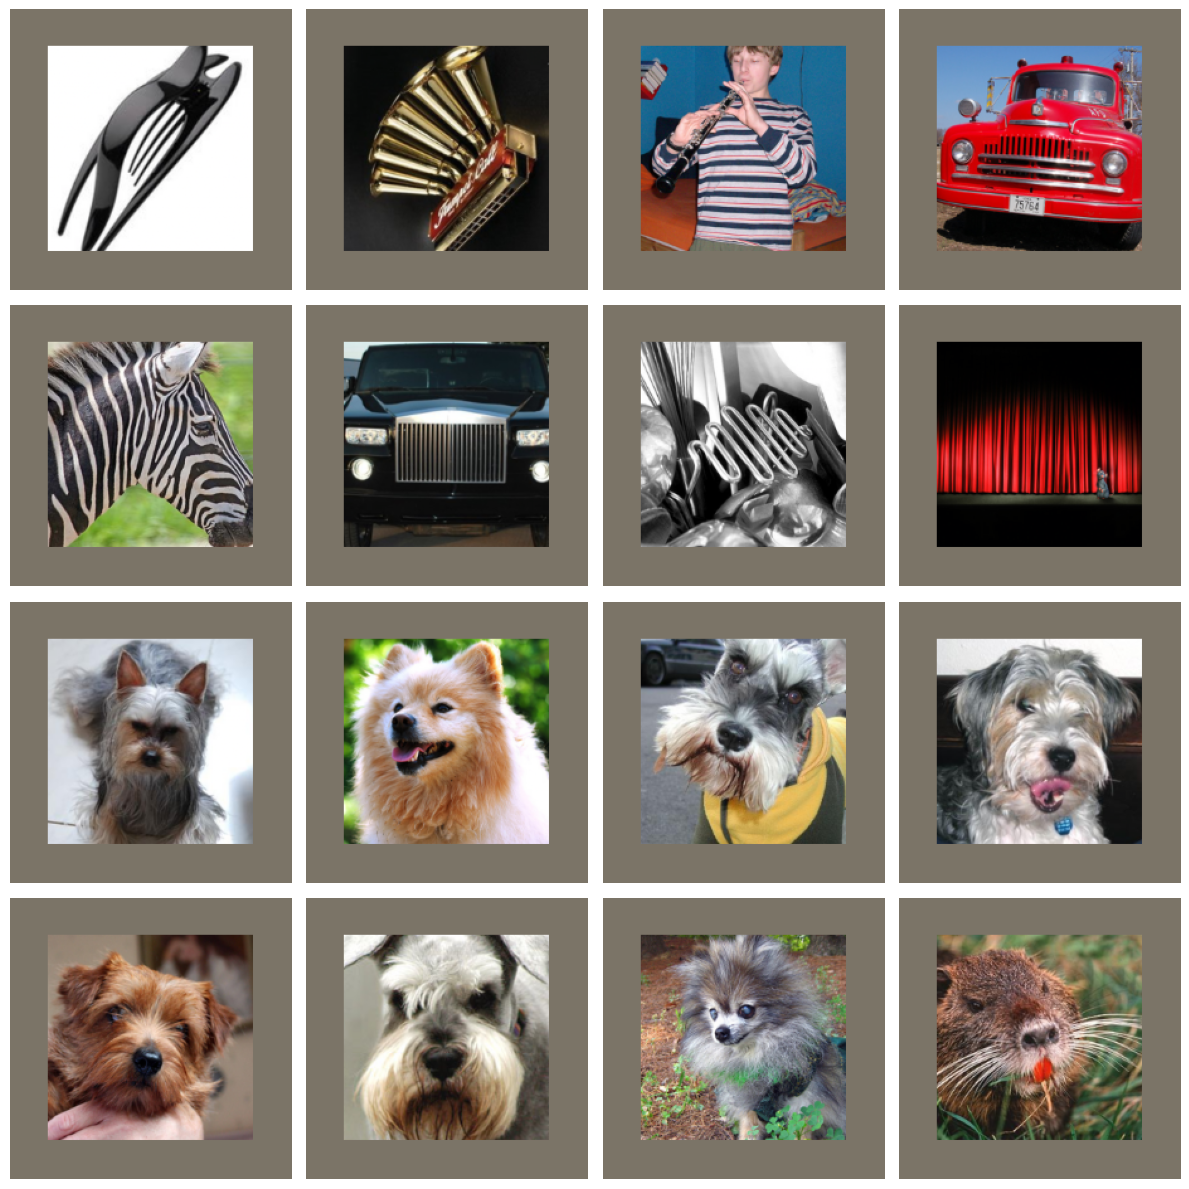

In [14]:
def cluster_and_plot_units(unit):
    original_activations = target_layer_activations[f'{layer}_{unit}']
    activations, indices = list(zip(*original_activations))
    sorted_idxs = np.flip(np.argsort(activations))
    sorted_activations = np.array(activations)[sorted_idxs]
    sorted_indices = np.array(indices)[sorted_idxs]
    
    values, idxs = sorted_activations, sorted_indices
    
    layer_activations = {}
    if isinstance(layer, str):
        layers = [layer]
    for i in layers:
        layer_activations[i] = []

    for i in range(len(idxs)):
        data = imagenet_train_dataset[idxs[i]]
        images = data[0].to(device)

        with layer_saver(model, layers) as extractor:
            batch_layer_activations = extractor(images.unsqueeze(0)) #all features for layer and all images in batch
            for i in layers:
                layer_activations[i].append(batch_layer_activations[i].detach().to('cpu'))

    for i in layers:     
        layer_activations[i] = torch.cat(layer_activations[i])

    cluster_points = layer_activations[layer][:,:,position[0],position[1]]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
    labels = clusterer.fit_predict(cluster_points.numpy())

    from circuit_explorer.data_loading import default_unnormalize

    plt.figure(figsize=(12, 12))
    num_images = 16
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        if i < int(num_images/2):
            plt.imshow(default_unnormalize(imagenet_train_dataset[random.choice(idxs[np.where(labels == 0)])][0]).numpy().transpose((1, 2, 0)))
        else:
            plt.imshow(default_unnormalize(imagenet_train_dataset[random.choice(idxs[np.where(labels == 1)])][0]).numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        plt.tight_layout()
    return values, idxs, labels
            
values, idxs, labels = cluster_and_plot_units(255)


# Good Polysemantic Neurons

### Layer 10
* 9 -- Dogs and Cylindrical Shape (Metal
* 15 -- Dogs and Flower
* 161 -- Dogs and Text
* 167 -- Red + White Dogs and Porcupines
* 255 -- Small Dogs and Stripes

# Subnetworking -- Unit 255

In [15]:
clusters = list(range(labels.max() + 1))

dataloaders = {}

for i, cluster in enumerate(clusters):
    cluster_indices = idxs[np.where(labels == cluster)]
    trainset = torch.utils.data.Subset(imagenet_train_dataset, cluster_indices)
    dataloaders[cluster] = DataLoader(
            trainset,
            batch_size=32,
            num_workers=1,
            shuffle=False,
            drop_last=False,
            pin_memory=True
        )


In [17]:
from circuit_explorer.score import actgrad_kernel_score, snip_score, force_score 

a_scores = {}
s_scores = {}
f_scores = {}
# we want to backprop the top activations in each image, this can be done by specifying a loss function that 
#operates on the output of each feature per batch 
loss_f = torch.max

for cluster in clusters:
    print(cluster)
    a_scores[cluster] = actgrad_kernel_score(model,dataloaders[cluster],layer,unit,loss_f = loss_f)
    s_scores[cluster] = snip_score(model,dataloaders[cluster],layer,unit,loss_f = loss_f)
    f_scores[cluster] = force_score(model,dataloaders[cluster],layer,unit,loss_f = loss_f)

0
pruning kernels
total parameters: 184768
parameters after pruning: 18477
keep ratio: 0.1
Pruning with 10 pruning steps
step 1
146767 params
step 2
116581 params
step 3
92604 params
step 4
73558 params
step 5
58430 params
step 6
46412 params
step 7
36867 params
step 8
29285 params
step 9
23262 params
step 10
18478 params
final mask: 18477/184768 params (0.10000108243851749)
1
pruning kernels
total parameters: 184768
parameters after pruning: 18477
keep ratio: 0.1
Pruning with 10 pruning steps
step 1
146767 params
step 2
116581 params
step 3
92604 params
step 4
73558 params
step 5
58430 params
step 6
46412 params
step 7
36867 params
step 8
29285 params
step 9
23262 params
step 10
18478 params
final mask: 18477/184768 params (0.10000108243851749)


In [20]:
all_scores = {'actgrad': a_scores, 'snip':s_scores, 'force':f_scores}
torch.save(all_scores, 'outputs/layer_10/all_scores.pt')

In [22]:
from circuit_explorer.target import layer_activations_from_dataloader

original_activations = {}
original_positions = {}
for cluster in clusters:
    target_layer_activations = layer_activations_from_dataloader(layer,dataloaders[cluster],model)[layer]
    unit_actmaps = target_layer_activations[:,unit]
    original_positions[cluster] = [6, 6]#actmap_maxpos(unit_actmaps) #where in the activation map are we trying to preserve
    original_activations[cluster] = torch.amax(unit_actmaps,dim=(1, 2)) #what was the orig activation

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.31it/s]


In [26]:
masked_layer_activations[i,255,6,6]

tensor([[[[ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02],
          [ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02],
          [ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02],
          ...,
          [ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02],
          [ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02],
          [ 3.6258e-02,  3.6258e-02,  3.6258e-02,  ...,  3.6258e-02,
            3.6258e-02,  3.6258e-02]],

         [[ 3.9238e-01,  3.9238e-01,  3.9238e-01,  ...,  3.9238e-01,
            3.9238e-01,  3.9238e-01],
          [ 3.9238e-01,  3.9238e-01,  3.9238e-01,  ...,  3.9238e-01,
            3.9238e-01,  3.9238e-01],
          [ 3.9238e-01,  3.9238e-01,  3.9238e-01,  ...,  3.9238e-01,
            3.9238e-01,  3.9238e-01],
          ...,
     

In [27]:
#calculate new circuit activations at different sparsities

import numpy as np
from circuit_explorer.mask import mask_from_scores, apply_mask
#from circuit_explorer.data_loading import single_image_data

sparsities = np.round(np.linspace(.2, .1, num=3),4)

sparsity_activations = {}
map_scores = {0: 'actgrad', 1:'snip', 2:'force'}

for i, scores in enumerate([a_scores, s_scores, f_scores]):
    sparsity_activations[map_scores[i]] = {}
    for circuit_cluster in clusters:
        print(f'{circuit_cluster} circuit')
        sparsity_activations[map_scores[i]][f'{circuit_cluster}_circuit'] = {}
        for data_cluster in clusters:
            print(f'{data_cluster} data')
            sparsity_activations[map_scores[i]][f'{circuit_cluster}_circuit'][f'{data_cluster}_data'] = []
            for sparsity in tqdm(sparsities):
                print(sparsity) 
                activations = [] 
                mask = mask_from_scores(scores[circuit_cluster],sparsity = sparsity, model=model,unit=unit,target_layer=layer)
                apply_mask(model,mask)
                masked_layer_activations = layer_activations_from_dataloader(layer,dataloaders[data_cluster],model)[layer]
                position = [6, 6]
                #get new activations at position
                activations.append(masked_layer_activations[:,unit,position[0],position[1]].half())
                #add those to the circuit activations at each sparsity
                sparsity_activations[map_scores[i]][f'{circuit_cluster}_circuit'][f'{data_cluster}_data'].append(activations)

0 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.39s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.37s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.36s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.07s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.10s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


1 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.34s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.34s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.07s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.05s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.07s/it]


0 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.39s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.41s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.40s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.08s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.10s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.11s/it]


1 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.38s/it]

0.15
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.40s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.39s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.07s/it]

0.15
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.07s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.08s/it]


0 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.35s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.34s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.03s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.04s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.03s/it]


1 circuit
0 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:01<00:02,  1.34s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:02<00:01,  1.34s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


1 data



  0%|                                                                                                                                 | 0/3 [00:00<?, ?it/s]

0.2



 33%|████████████████████████████████████████▎                                                                                | 1/3 [00:03<00:06,  3.01s/it]

0.15



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 2/3 [00:06<00:03,  3.03s/it]

0.1



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.03s/it]


In [28]:
torch.save(sparsity_activations, 'outputs/layer_10/sparsity_activations.pt')

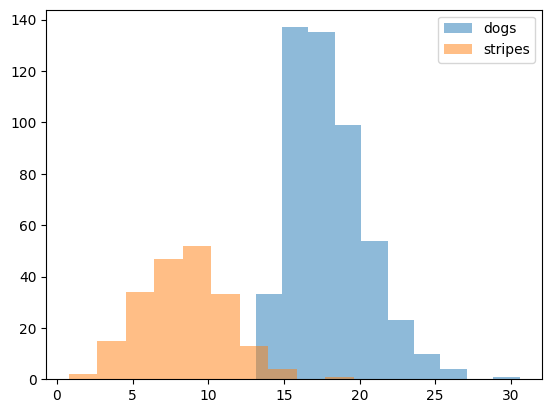

In [70]:
plt.hist(sparsity_activations['actgrad']['1_circuit']['1_data'][1][0],
         alpha=0.5,
         label='dogs')
plt.hist(sparsity_activations['actgrad']['1_circuit']['0_data'][1][0], 
         alpha=0.5, # the transaparency parameter
         label='stripes')
  

  
plt.legend(loc='upper right')
plt.show()

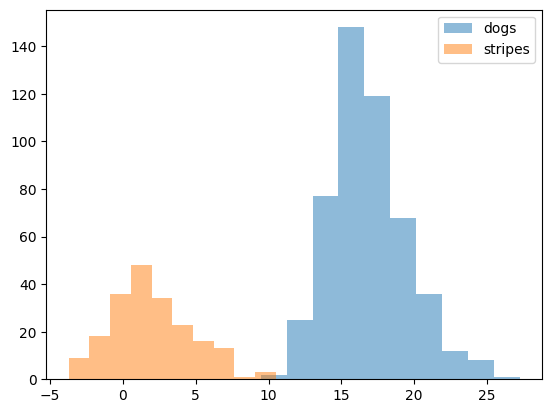

In [71]:
plt.hist(sparsity_activations['force']['1_circuit']['1_data'][2][0],
         alpha=0.5,
         label='dogs')

plt.hist(sparsity_activations['force']['1_circuit']['0_data'][2][0], 
         alpha=0.5, # the transaparency parameter
         label='stripes')
  
plt.legend(loc='upper right')
plt.show()

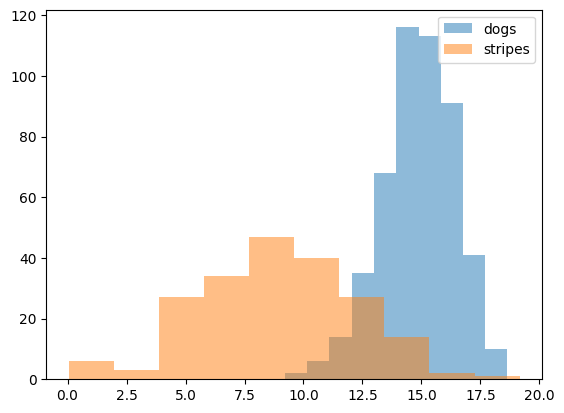

In [68]:
plt.hist(20 - sparsity_activations['snip']['1_circuit']['1_data'][1][0],
         alpha=0.5,
         label='dogs')

plt.hist(20- sparsity_activations['snip']['1_circuit']['0_data'][1][0], 
         alpha=0.5, # the transaparency parameter
         label='stripes')
  
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(sparsity_activations['snip']['1_circuit']['0_data'][0], 
         alpha=0.5, # the transaparency parameter
         label='stripes')
  
plt.hist(sparsity_activations['snip']['1_circuit']['1_data'][0],
         alpha=0.5,
         label='dogs')
  
plt.legend(loc='upper right')
plt.show()

In [ ]:
sparsity_activations['snip']['1_circuit']['0_data']
sparsity_activations['snip']['1_circuit']['1_data']

In [ ]:
sparsity_activations['force']['1_circuit']['0_data']
sparsity_activations['force']['1_circuit']['1_data']

In [25]:
import plotly.graph_objects as go
import plotly.express as px


color_dict = {
               f'{clusters[0]}_circuit':px.colors.qualitative.T10[0],
               f'{clusters[1]}_circuit':px.colors.qualitative.T10[1],
             }

fig = go.Figure()

for circuit in sparsity_activations:
    for data in sparsity_activations[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (f'{circuit} : {data}').replace('_',' ').replace('1','2').replace('0','1').replace('data','images')
        #get diff metric
        y = []
        for i in range(len(sparsity_activations[circuit][data])):
            circuit_acts = torch.tensor(sparsity_activations[circuit][data][i])
            orig_acts = original_activations[int(data.replace('_data',''))]
            y.append(torch.mean(torch.abs(circuit_acts - orig_acts))/torch.mean(torch.abs(orig_acts)))

        x = sparsities
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=4,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'${\Delta\mathcal{F}_{norm}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.95,
                                xanchor="left",
                                x=0.03,
                                bgcolor='rgba(255,255,255,0.3)'
                              )
                 )

fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=1)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=1)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.5, .4, .3, .2, .1]
    )
)
fig.show()

original


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 135.05it/s]



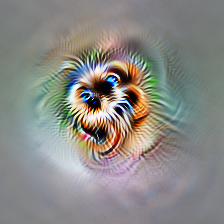

final loss: -147.068
0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 163.79it/s]



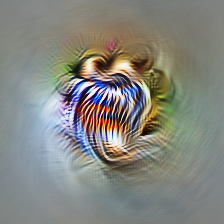

final loss: -100.649
1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 163.26it/s]



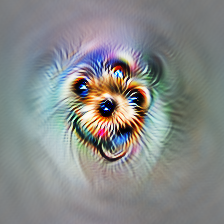

final loss: -160.829


In [26]:
unit=255


setup_net_for_mask(model) #resets mask to all 1s

obj  = objectives.neuron(layer.replace('.','_'),unit)
param_f = lambda: param.image(224)

print('original')
_ = render.render_vis(model,obj,param_f)

target_sparsities = {'cluster_0':0.12,
                     'cluster_1':0.11
                    }

masks = {}

for cluster in clusters:
    masks[cluster] = mask_from_scores(scores[cluster],sparsity = target_sparsities[f'cluster_{cluster}'], model=model,unit=unit,target_layer=layer)
for m in masks:
    apply_mask(model,masks[m])
    print(m)
    _ = render.render_vis(model,obj,param_f)

original


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 140.36it/s]



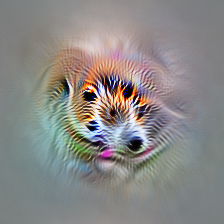

final loss: -100.408


In [20]:
unit = 167

setup_net_for_mask(model) #resets mask to all 1s

obj  = objectives.neuron(layer.replace('.','_'),unit)
param_f = lambda: param.image(224)

print('original')
_ = render.render_vis(model,obj,param_f)

In [27]:
target_sparsities

{'cluster_0': 0.12, 'cluster_1': 0.11}

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
from torchvision.models import AlexNet

def sigmoid(x):
    return float(1./(1.+np.exp(-x)))

class SoftMaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, mask_initial_value=0., temp=1):
        super(SoftMaskedConv2d, self).__init__()
        self.mask_initial_value = mask_initial_value
        
        self.in_channels = in_channels
        self.out_channels = out_channels    
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.temp = temp
        
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        nn.init.xavier_normal_(self.weight)
        
    def init_mask(self):
        self.weight_mask = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        nn.init.constant_(self.weight_mask, 0)
        
        self.bias_mask = nn.Parameter(torch.Tensor(self.out_channels))
        nn.init.constant_(self.bias_mask, 0)


    def compute_mask(self, temp, ticket):
        #scaling = 1. / sigmoid(self.mask_initial_value)
        if ticket: mask = (self.weight_mask > 0).float() 
        else: mask = F.sigmoid(temp * self.weight_mask)
        return mask # * scaling   
    
    def compute_mask_bias(self, temp, ticket):
        #scaling = 1. / sigmoid(self.mask_initial_value)
        if ticket: mask = (self.bias_mask > 0).float()
        else: mask = F.sigmoid(temp * self.bias_mask)
        return mask # * scaling
        
    def prune(self, temp):
        self.weight_mask.data = torch.clamp(temp * self.weight_mask.data, max=self.mask_initial_value)
        self.bias_mask.data = torch.clamp(temp * self.bias_mask.data, max=self.mask_initial_value)

    def forward(self, x, ticket=False):
        self.mask = self.compute_mask(self.temp, ticket)
        masked_weight = self.weight * self.mask
    
        self.mask_bias = self.compute_mask_bias(self.temp, ticket)
        masked_bias = self.bias * self.mask_bias
        out = F.conv2d(x, masked_weight, bias=masked_bias, stride=self.stride, padding=self.padding)        
        return out

    def extra_repr(self):
        return '{}, {}, kernel_size={}, stride={}, padding={}'.format(
            self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)

In [23]:
from functools import partial
 
class MaskedNet(nn.Module):
    def __init__(self):
        super(MaskedNet, self).__init__()
        self.ticket = False

    def checkpoint(self):
        for m in self.mask_modules: m.checkpoint()
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
                m.checkpoint = copy.deepcopy(m.state_dict())

    def rewind_weights(self):
        for m in self.mask_modules: m.rewind_weights()
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
                m.load_state_dict(m.checkpoint)
                
    def prune(self):
        for m in self.mask_modules: m.prune(self.temp)
            
class AlexNetMasking(MaskedNet):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.dropout = dropout
        Conv = partial(SoftMaskedConv2d, mask_initial_value=0.0) 
        self.features = nn.Sequential(
            Conv(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Conv(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Conv(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            Conv(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            Conv(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.mask_modules = [m for m in self.modules() if isinstance(m, SoftMaskedConv2d)]
        self.temp = 1
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def model_init_mask(self):
        for p in self.parameters():
            p.requires_grad_(False)
        for child_sub in self.features:
            if isinstance(child_sub, SoftMaskedConv2d):
                child_sub.init_mask()
                child_sub.weight_mask.requires_grad_(True)
                child_sub.bias_mask.requires_grad_(True)
    def run_to_conv_layer(self, batch, layer_name_stop_point):
        features = list(self.named_children())[0][1]
        for layer_name, layer in list(features.named_children()):
            batch = layer(batch)
            if layer_name == layer_name_stop_point:
                break
        return batch

In [57]:
class ImageNetClusters(ImageNetReceptiveField):
    def __init__(self, root, split, clusters, transform=transforms.ToTensor(),
                 background_c =(255,255,255), recep_field=None, img_size=224):
        
        super().__init__(root, split, transform=transform,
                 background_c =background_c, recep_field=recep_field, img_size=img_size)
        self.clusters = clusters
                
    def __len__(self):
        return super().__len__()
        
    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        lab = self.clusters[idx]
        return img, lab

In [58]:
both_cluster_indices = idxs[np.concatenate((np.where(labels == 0)[0], np.where(labels == 1)[0]))]
both_cluser_labels = [0] * len(np.where(labels == 0)[0]) + [1] * len(np.where(labels == 1)[0])
#both_cluser_labels = 1 - np.array(both_cluser_labels) ## if you want to switch labels
clusters_indices = {clust_ind:clust_lab for clust_ind, clust_lab in zip(both_cluster_indices, both_cluser_labels)}
subset_clusters_indices = {i:clust_lab for i,clust_lab in enumerate(both_cluser_labels)}

imagenet_cluster_dataset = ImageNetClusters('image_data/imagenet', "train", clusters=clusters_indices, 
                                          transform=preprocessing, recep_field=recep_field)

trainset_both_clusters = torch.utils.data.Subset(imagenet_cluster_dataset, both_cluster_indices)
dataloader_both_clusters = DataLoader(
        trainset_both_clusters,
        batch_size=32,
        num_workers=1,
        shuffle=True,
        drop_last=False,
        pin_memory=True
    )

In [59]:
batch_size = 32
epochs = 160
rounds = 3
lr = 0.1
seed = 1234
lr_schedule = [25, 46] 
lr_drops = [0.1, 0.1]
decay = 0.0001
lmbda = 1e-6
final_temp = 200
mask_initial_value = 0

In [60]:
def run_to_layer(batch, model, layer_name_stop_point):
    features = list(model.named_children())[0][1]
    for layer_name, layer in list(features.named_children()):
        batch = layer(batch)
        if layer_name == layer_name_stop_point:
            break
    return batch

In [61]:
def adjust_learning_rate(optimizer, epoch):
    global lr
    assert len(lr_schedule) == len(lr_drops), "length of gammas and schedule should be equal"
    for (drop, step) in zip(lr_drops, lr_schedule):
        if (epoch >= step): lr = lr * drop
        else: break
    for param_group in optimizer.param_groups: param_group['lr'] = lr

In [62]:
def compute_remaining_weights(masks):
    return 1 - sum(float((m == 0.).sum()) for m in masks) / sum(m.numel() for m in masks)

In [63]:
from functools import reduce


def train(outer_round, model, dataloader, optimizer, layer='10', unit=255, position=[6, 6]):
    remaining_weights = 1
    
    for epoch in range(epochs):
        model.train()
        if epoch > 0:
            model.temp *= temp_increase
            for conv_mask in model.mask_modules:
                conv_mask.temp = model.temp
        adjust_learning_rate(optimizer, epoch)

        pbar = tqdm(dataloader)
        acc_batch = []
        
        for batch_idx, (data, target) in enumerate(pbar):
            target = target.float()
            optimizer.zero_grad()

            output = run_to_layer(data, model, layer)[:, unit, position[0], position[1]]

            pred = output > 0
            batch_correct = pred.eq(target.data.view_as(pred)).sum()
            curr_acc = batch_correct/len(target)
            acc_batch.append(curr_acc.item())
            
            
            loss1 = F.binary_cross_entropy_with_logits(output, target) 
            masks = [m.mask for m in model.mask_modules] ##TODO: Include Bias Mask
            weight_masks = [[m.weight_mask, m.bias_mask] for m in model.mask_modules]
            weight_masks = reduce(lambda a,b: a+b, weight_masks)
            entries_sum = sum(m.sum() for m in masks)
            loss2 = lmbda * entries_sum 
            
#             loss2 = torch.sum(torch.stack([F.l1_loss(m.mask, torch.zeros(m.mask.shape)) for m in model.mask_modules]))

            loss = loss1 + loss2
#             weight_masks[0].retain_grad()
            loss.backward()
#             print(weight_masks[0].grad)

            optimizer.step()
            
            acc = np.mean(acc_batch)
            total_epoch_num = outer_round * epochs + epoch
            pbar.set_postfix(temp=model.temp, remaining_weights=remaining_weights, acc=acc,
                             class_loss=loss1.item(), l0_loss=loss2.item(), total_epoch_num=total_epoch_num)
        
        remaining_weights = compute_remaining_weights(masks)

In [64]:
alexnet_masking = AlexNetMasking()
model_statedict = torch.load('./models/alexnet_sparse_statedict.pt',map_location='cpu')
alexnet_masking.load_state_dict(model_statedict)

<All keys matched successfully>

In [65]:
alexnet_masking.model_init_mask()

In [66]:
model = alexnet_masking
iters_per_reset = epochs-1
temp_increase = final_temp**(1./iters_per_reset)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([p.numel() for p in trainable_params])
print("Total number of parameters: {}".format(num_params))

weight_params = map(lambda a: a[1], filter(lambda p: p[1].requires_grad and 'mask' not in p[0], model.named_parameters()))
mask_params = map(lambda a: a[1], filter(lambda p: p[1].requires_grad and 'mask' in p[0], model.named_parameters()))

model.ticket = False
# weight_optim = optim.SGD(weight_params, lr=lr, momentum=0.9, nesterov=True, weight_decay=decay)
mask_optim = optim.SGD(mask_params, lr=lr)
# optimizers = [mask_optim] # weight_optim,


Total number of parameters: 2469696


**Updates**

1. Train 90 epochs
2. Decrease temperature to 200 -- Want temperature to smoothly increase to a value
3. Nix the rounds, triple the number of epochs -- this was in comparison to the lottery ticket hypothesis
4. Accuracy in train mode --> during validation soft masks become hard mask, so need to check that
5. Make a validation data set -- could just use training set as well
6. Between 1-10% feels right for the sparsity -- this is problem dependent
7. Can kind of choose sparsity through mask initialization (higher to less sparse, and lower to more sparse -- could decrease magnitude of lambda as well)

**Design**
1. Might help to just take the previous ConvNet Layer or MLP (lot of stuff early in the network that affects everything or is not relevant) --> can kick off multiple
2. Want random images that are the same the class
3. Histogram about how they were overlapping and high to low and high

In [69]:
for outer_round in range(1):
    print('--------- Round {} -----------'.format(outer_round))
    model.temp = 1
    train(outer_round, model, dataloader_both_clusters, mask_optim)
    if outer_round != rounds-1: model.prune()

# print('--------- Training final ticket -----------')
# optimizers = [optim.SGD(weight_params, lr=lr, momentum=0.9, nesterov=True, weight_decay=decay)]
# model.ticket = True
# model.rewind_weights()
# train(outer_round)

--------- Round 0 -----------


 91%|███████████████████████████▎  | 20/22 [04:35<00:27, 13.77s/it, acc=0.706, class_loss=0.383, l0_loss=1.23, remaining_weights=1, temp=4.48, total_epoch_num=45]Traceback (most recent call last):
  File "/gpfs/runtime/opt/python/3.8.12_gcc8.3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/gpfs/runtime/opt/python/3.8.12_gcc8.3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/gpfs/runtime/opt/python/3.8.12_gcc8.3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/gpfs/runtime/opt/python/3.8.12_gcc8.3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe



KeyboardInterrupt: 

## Questions:

1. Is this expected behavior
2. Is our classification method acceptable?
3. Should we have a train and a test?
3. Make greater than 0 to be 1 for mask_weights?
4. Potential reasons viz might not work
5. Dataset side

In [40]:
model_state_dict = torch.load('outputs/layer_10/model_unit_255_mask_rev.py')
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), 'outputs/layer_10/model_unit_255_mask_rev1.py')

In [47]:
masks = [(m.weight_mask > 0).float() for m in model.mask_modules]

In [49]:
1 - sum(float((m == 0.).sum()) for m in masks) / sum(m.numel() for m in masks)

0.01165828925876955

### Mask Fixing

In [808]:
from collections import OrderedDict

model_state_dict = model.state_dict()
masked_model_state_dict = OrderedDict()
for feature_name, tensor_weights in model_state_dict.items():
    if 'features' in feature_name:
        if 'weight_mask' in feature_name:
            weight_name = '.'.join(feature_name.split('.')[:-1])+'.weight'
            masked_model_state_dict[weight_name] = torch.mul(model_state_dict[weight_name], (tensor_weights > 0).float())

        elif 'bias_mask' in feature_name:
            bias_name = '.'.join(feature_name.split('.')[:-1])+'.bias'
            masked_model_state_dict[bias_name] = torch.mul(model_state_dict[bias_name], (tensor_weights > 0).float())
    elif 'mask' not in feature_name:
        masked_model_state_dict[feature_name] = tensor_weights
    

original


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 95.03it/s]



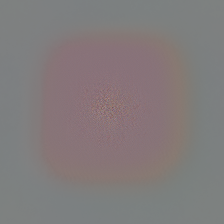

final loss: 0.523
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
gradients from this feature are sparse, the minimum acceptable score at this sparsity has a score of zero! we will return a mask thats smaller than you asked, by masking all parameters with a score of zero.
0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 96.28it/s]



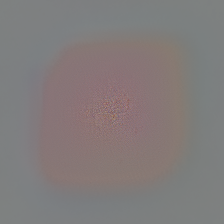

final loss: 0.139
1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:05<00:00, 96.28it/s]



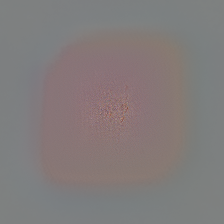

final loss: 0.163


In [916]:
masked_model = torchvision.models.alexnet(pretrained=True)

masked_model.load_state_dict(masked_model_state_dict)
masked_model = masked_model.eval().to(device)

setup_net_for_mask(masked_model) #resets mask to all 1s

obj  = objectives.neuron(layer.replace('.','_'),unit)
param_f = lambda: param.image(224)

print('original')
_ = render.render_vis(masked_model,obj,param_f)

target_sparsities = {'cluster_0':0.12,
                     'cluster_1':0.11
                    }

unit=255
masks = {}

for cluster in clusters:
    masks[cluster] = mask_from_scores(scores[cluster],sparsity = target_sparsities[f'cluster_{cluster}'], model=masked_model,unit=unit,target_layer=layer)
for m in masks:
    apply_mask(masked_model,masks[m])
    print(m)
    _ = render.render_vis(masked_model,obj,param_f)

## Mikey's Implementation

## Conv Unit

In [889]:
class L0Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, dilation=1, groups=1, bias=False, l0=False, mask_init_value=0., temp: float = 1., ablate_mask=None):
        super(L0Conv2d, self).__init__()
        self.l0 = l0
        self.mask_init_value = mask_init_value
        
        self.in_channels = in_channels
        self.out_channels = out_channels    
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.dilation = _pair(dilation)
        self.groups = groups
        self.temp = temp
        self.ablate_mask=ablate_mask

        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

        # Create a random tensor to reinit ablated parameters
        if self.ablate_mask == "random":
            self.random_weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
            init.kaiming_uniform_(self.random_weight, a=math.sqrt(5))
            self.random_weight.requires_grad=False

        
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        if self.l0:
            self.init_mask()

        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)
                
    def init_mask(self):
        self.mask_weight = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        nn.init.constant_(self.mask_weight, self.mask_init_value)

    def compute_mask(self):
        if (self.ablate_mask == None) and (not self.training or self.mask_weight.requires_grad == False): 
            mask = (self.mask_weight > 0).float() # Hard cutoff once frozen or testing
        elif (self.ablate_mask != None) and (not self.training or self.mask_weight.requires_grad == False): 
            mask = (self.mask_weight <= 0).float() # Used for subnetwork ablation
        else:
            mask = F.sigmoid(self.temp * self.mask_weight)
        return mask 

    def train(self, train_bool):
        self.training = train_bool         
        
    def forward(self, x):
        if self.l0:
            self.mask = self.compute_mask()
            if self.ablate_mask == "random":
                masked_weight = self.weight * self.mask # This will give you the inverse weights, 0's for ablated weights
                masked_weight += (~self.mask.bool()).float() * self.random_weight # Invert the mask to target the remaining weights, make them random
            else:
                masked_weight = self.weight * self.mask
        else:
            masked_weight = self.weight
        
        out = F.conv2d(x, masked_weight, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=self.groups)   
        return out


    def extra_repr(self):
        return '{}, {}, kernel_size={}, stride={}, padding={}'.format(
            self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)

## AlexNet

In [ ]:
class AlexNetMasking2(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5, 
                isL0: bool = False,
                mask_init_value: float = 0.,
                embed_dim:int = 10,
                ablate_mask:str = None) -> None:
        
        super().__init__()
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.isL0 = isL0
        self.ablate_mask = ablate_mask # Used during testing to see performance when found mask is removed
        self.embed_dim = embed_dim
        self.temp = 1.
        
        L0_Conv = functools.partial(L0Conv2d, l0=True, mask_init_value=mask_init_value, ablate_mask=self.ablate_mask)
        Conv = functools.partial(L0Conv2d, l0=False)
        self.features = nn.Sequential(
            L0_Conv(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            L0_Conv(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            L0_Conv(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            L0_Conv(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            L0_Conv(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, L0Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                if m.weight is not None and m.bias is not None:
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                    
        self.mask_modules = [m for m in self.modules() if isinstance(m, SoftMaskedConv2d)]
        self.temp = 1
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def model_init_mask(self):
        for p in self.parameters():
            p.requires_grad_(False)
        for child_sub in self.features:
            if isinstance(child_sub, L0_Conv):
                child_sub.init_mask()
                child_sub.weight_mask.requires_grad_(True)
                child_sub.bias_mask.requires_grad_(True)
                
    def get_temp(self):
        return self.temp

    def set_temp(self, temp):
        self.temp = temp
        for layer in self.modules():
            if type(layer) == L0Conv2d:
                layer.temp = temp


In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn as nn
from torch.nn import functional as F
import numpy as np
from models.resnet import *
from models.decisionMLP import MLP, L0Linear
from transformers import ViTModel, ViTConfig
import functools

class Base(pl.LightningModule):
    def load_finetune_weights(self, checkpoint):
        print("*"*10 + "load finetune weights ...")
        model_temp = self.__class__.load_from_checkpoint(checkpoint)
        # model.load_finetune_weights(model_temp)
        self.backbone.load_state_dict(model_temp.backbone.state_dict())

    def load_backbone_weights(self, checkpoint):
        print("*"*10 + "load ckpt weights ...")
        self.backbone.load_state_dict(torch.load(checkpoint)['model'], strict=False)


    def freeze_pretrained(self):
        for param in self.backbone.parameters():
            param.requires_grad = False


    def l0_loss(self, y_hat, y, test_mode=False):
        if test_mode:
            error_loss = F.binary_cross_entropy_with_logits(y_hat, y, reduction="none")
        else:
            error_loss = F.binary_cross_entropy_with_logits(y_hat, y)

        l0_loss = 0.0
        masks = []
        if self.train_masks["backbone"]:
            for layer in self.backbone.modules():
                if hasattr(layer, "mask_weight"):
                    masks.append(layer.mask)
        l0_loss = sum(m.sum() for m in masks)
        return (error_loss + (self.lamb * l0_loss), l0_loss)
    
    def step(self, batch, batch_idx):

        y_hat, y = self.shared_step(batch)

        if self.train_masks["backbone"] or self.train_masks["mlp"]:
            loss, l0_loss = self.l0_loss(y_hat, y)
        else:
            loss = F.cross_entropy(y_hat, y)
            l0_loss = torch.zeros(loss.shape)

        acc = torch.sum((y == torch.argmax(y_hat, dim=1))).float() / len(y)

        logs = {
            "loss": loss.reshape(1),
            "acc": acc.reshape(1),
            "L0": l0_loss.reshape(1)
        }

        return loss, logs

   
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

In [ ]:
if self.train_weights["backbone"] == False:
    for layer in self.backbone.modules():
        if hasattr(layer, "weight") and layer.weight != None:
            layer.weight.requires_grad = False
        if hasattr(layer, "bias") and layer.bias != None: 
                layer.bias.requires_grad = False

In [ ]:
def train2(outer_round, model, dataloader, optimizer, layer='10', unit=255, position=[6, 6]):
    remaining_weights = 0
    
    for epoch in range(epochs):
        model.train()
        if epoch > 0: model.temp *= temp_increase
        adjust_learning_rate(optimizer, epoch)

        pbar = tqdm(dataloader)
        acc_batch = []
        
        for batch_idx, (data, target) in enumerate(pbar):
            target = target.float()
            optimizer.zero_grad()

            output = run_to_layer(data, model, layer)[:, unit, position[0], position[1]]

            pred = output > 0
            batch_correct = pred.eq(target.data.view_as(pred)).sum()
            curr_acc = batch_correct/len(target)
            acc_batch.append(curr_acc.item())
            
            
            loss1 = F.binary_cross_entropy_with_logits(output, target) 
            masks = [m.mask for m in model.mask_modules] ##TODO: Include Bias Mask
            weight_masks = [[m.weight_mask, m.bias_mask] for m in model.mask_modules]
            weight_masks = reduce(lambda a,b: a+b, weight_masks)
            entries_sum = sum(m.sum() for m in masks)
            loss2 = lmbda * entries_sum 
            
#             loss2 = torch.sum(torch.stack([F.l1_loss(m.mask, torch.zeros(m.mask.shape)) for m in model.mask_modules]))

            loss = loss1 + loss2
#             weight_masks[0].retain_grad()
            loss.backward()
#             print(weight_masks[0].grad)

            optimizer.step()
            
            acc = np.mean(acc_batch)
            total_epoch_num = outer_round * epochs + epoch
            pbar.set_postfix(temp=model.temp, remaining_weights=remaining_weights, acc=acc,
                             class_loss=loss1.item(), l0_loss=loss2.item(), total_epoch_num=total_epoch_num)
        
        remaining_weights = compute_remaining_weights(masks)

In [906]:
alexnet_masking = AlexNetMasking()
model_statedict = torch.load('./models/alexnet_sparse_statedict.pt',map_location='cpu')
alexnet_masking.load_state_dict(model_statedict)

<All keys matched successfully>

In [907]:
alexnet_masking.model_init_mask()

In [908]:
model = alexnet_masking
iters_per_reset = epochs-1
temp_increase = final_temp**(1./iters_per_reset)

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([p.numel() for p in trainable_params])
print("Total number of parameters: {}".format(num_params))

weight_params = map(lambda a: a[1], filter(lambda p: p[1].requires_grad and 'mask' not in p[0], model.named_parameters()))
mask_params = map(lambda a: a[1], filter(lambda p: p[1].requires_grad and 'mask' in p[0], model.named_parameters()))

model.ticket = False
# weight_optim = optim.SGD(weight_params, lr=lr, momentum=0.9, nesterov=True, weight_decay=decay)
mask_optim = optim.SGD(mask_params, lr=lr)
# optimizers = [mask_optim] # weight_optim,


Total number of parameters: 2469696


In [ ]:
for outer_round in range(rounds):
    print('--------- Round {} -----------'.format(outer_round))
    train(outer_round, model, dataloader_both_clusters, mask_optim)
    model.temp = 1
    if outer_round != rounds-1: model.prune()

# print('--------- Training final ticket -----------')
# optimizers = [optim.SGD(weight_params, lr=lr, momentum=0.9, nesterov=True, weight_decay=decay)]
# model.ticket = True
# model.rewind_weights()
# train(outer_round)

--------- Round 0 -----------


100%|█████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.55s/it, acc=0.996, class_loss=0.0814, l0_loss=0.0838, remaining_weights=0.0466, temp=2e+4, total_epoch_num=9]


--------- Round 1 -----------


100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.55s/it, acc=0.996, class_loss=0.00101, l0_loss=0.0314, remaining_weights=0.0143, temp=2e+4, total_epoch_num=19]


--------- Round 2 -----------


 47%|████████████████████████████████████▍                                         | 7/15 [00:11<00:13,  1.67s/it, acc=0.857, class_loss=5.75, l0_loss=0.986, remaining_weights=0.997, temp=245, total_epoch_num=25]